# Real Estate Values Around Houston Heights District

By Valentina Fontiveros

## Objective

The objective of this study is to describe real estate values around Roovy's sphere of influence

## Methods

- Data Source: Zillow home values (1996 - 2018)
- Zipcode Selection Criteria: 

> Location around Houston Heights

- Using Arima modeling, forecast potential home values for the next __ years.

## Import Libraries

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
import statistics as stats
from matplotlib.pylab import rcParams
from pandas import Grouper
from collections import Counter
plt.style.use('seaborn-bright')
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

## Import Zillow Data and Preview

Zillow provides free access to its API. The dataset read here contains data for historical home values in the United States between 1996 and 2018. 

In [3]:
# read in data and preview
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Data Preprocessing

All numerical entries are converted to float format.
It is always important to understand how much missing data there is, so the dataset is scanned for NaN entries.

In [4]:
# Convert all data columns to type: float
for c in df.columns[7:]:
    df[c] = df[c].astype(float)
    
# Understand Percent of NaN Entries
c_entries = len(df.RegionID)
n_entries = df.size
nan_entries = df.isna().sum().sum()
print('Entries per column:                    '  , c_entries)
print('Total entries:                         '  , n_entries)
print('Total NaN entries:                     '  , nan_entries)

# Check for columns for NaNs entries greater than 10%
print('Percent of NaN entries:                '  , round(100*nan_entries/n_entries, 2))
print('Columns with 5% or more NaN Entries:   '  ,    (df.isna().sum()/c_entries > .05).sum())
print('Columns with 10% or more NaN Entries:  '  ,    (df.isna().sum()/c_entries > .1).sum())

Entries per column:                     14723
Total entries:                          4004656
Total NaN entries:                      157934
Percent of NaN entries:                 3.94
Columns with 5% or more NaN Entries:    112
Columns with 10% or more NaN Entries:   0


This is, overall, a very good quality dataset, with only 4% NaN entries.

Next, dates are transformed to datetime format. A copy of the dataset is generated for data wrangling.

In [5]:
# convert columns with dates to datetime format

pd.to_datetime(df.columns.values[7:], format='%Y-%m')



DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

## 1st Step for Zipcode Selection
### Find Zipcodes where values increased most months of the year.

The strategy pursued is to invest in real estate with a strong historical
performance. 

In [6]:
# List zipcodes in area of interest

hou_zips = [77002,77006,77007,77008,77009,77018,77019,77022]


# Optimize data format for analysis

In [7]:
# define a function to convert from long format to short format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','SizeRank','RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time',inplace=True)
    melted.dropna(inplace=True)
    return melted
    #return melted.groupby('time').aggregate({'value':'mean'})

In [8]:
# create a short format dataframe to hold data for top zipcodes
zip_df = pd.DataFrame()
for z in hou_zips:
    d = melt_data(df[df.RegionName==z])
    zip_df = pd.concat([d,zip_df])
zip_df.head()

,RegionID,SizeRank,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,91668,3043,77019,Houston,TX,Houston,Harris,402200.0
1996-05-01,91668,3043,77019,Houston,TX,Houston,Harris,398800.0
1996-06-01,91668,3043,77019,Houston,TX,Houston,Harris,395500.0
1996-07-01,91668,3043,77019,Houston,TX,Houston,Harris,392200.0
1996-08-01,91668,3043,77019,Houston,TX,Houston,Harris,389400.0


In [18]:
zip_df[zip_df.RegionName==77022]

,RegionID,SizeRank,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,


# Data Visualization

Plot overall trend of values in zipcodes selected

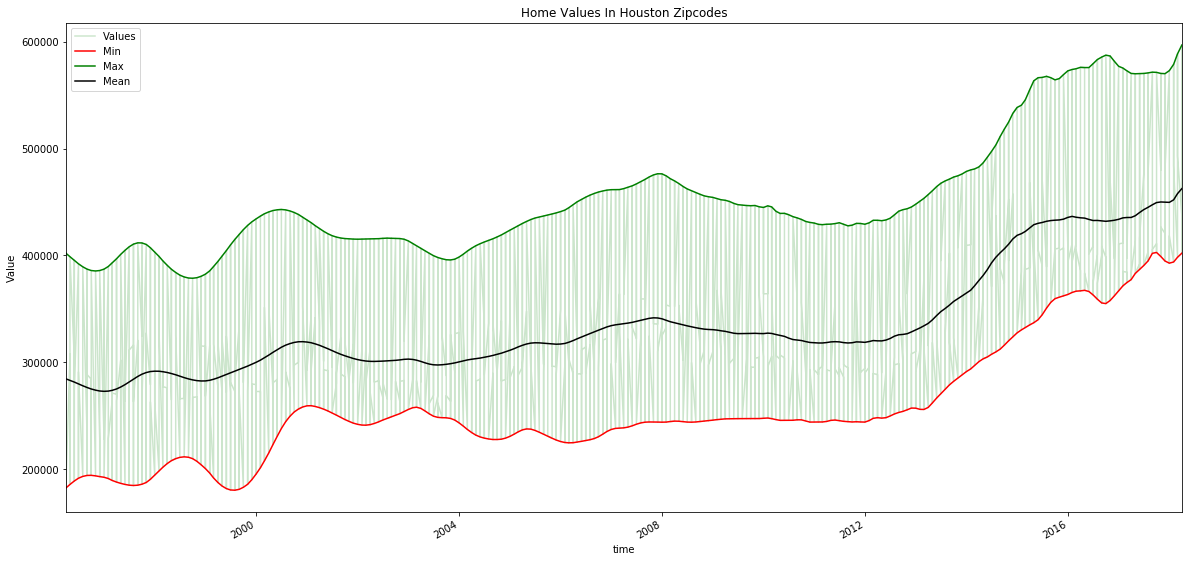

In [11]:
# plot the entirety of data for all zipcodes and observe overall trend
# make sure this satisfies criteria: (Low STD and overall increasing trend)

zip_df.value.plot(figsize=(20,10),label='Values',color='green',alpha=0.2)
min_ = zip_df.groupby('time').aggregate({'value':'min'})
max_ = zip_df.groupby('time').aggregate({'value':'max'})
mean_ = zip_df.groupby('time').aggregate({'value':'mean'})
plt.plot(min_, color= 'red',label='Min')
plt.plot(max_, color='green',label = 'Max')
plt.plot(mean_, color= 'black',label= 'Mean')
plt.legend()
plt.title('Home Values In Houston Zipcodes')
plt.ylabel('Value')
plt.show()

Plot each zipcode for QC

Text(0.5, 0.98, 'Top Zipcodes')

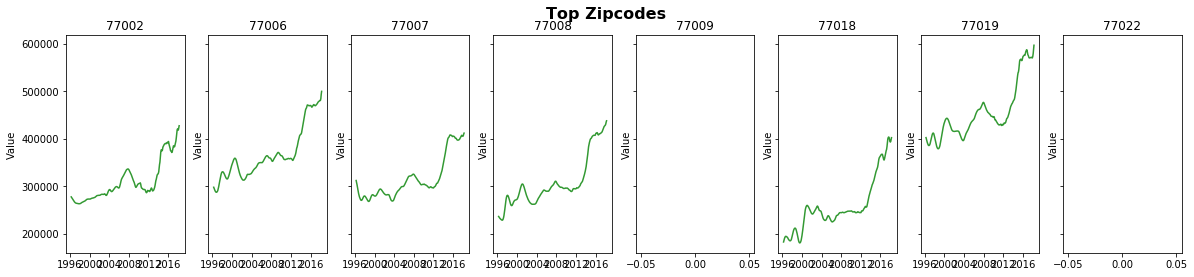

In [17]:
fig, axs = plt.subplots(1,8,figsize=(20,4),sharey=True)
for ax, column, index in zip(axs,hou_zips, range(0,8)):
    ax.plot(zip_df[zip_df.RegionName ==column].value, color='green',alpha=0.8)
    ax.set_title(column)
    ax.set_ylabel('Value')
fig.suptitle('Top Zipcodes', fontsize=16, fontweight='bold')

All looks good

# Modeling and Forecasting - ARIMA

### Stationarity test

In [19]:
# test each zipcode for stationarity using the AD Fuller Test.
zipcodes = zip_df.RegionName.sort_values().unique()

from statsmodels.tsa.stattools import adfuller
from numpy import log

for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
    result = adfuller(df_z.value.dropna())
    print('Zip: ', z)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

Zip:  77002
ADF Statistic: 0.410857
p-value: 0.981896
Zip:  77006
ADF Statistic: 1.198381
p-value: 0.995975
Zip:  77007
ADF Statistic: -0.186661
p-value: 0.940093
Zip:  77008
ADF Statistic: 0.084668
p-value: 0.964999
Zip:  77018
ADF Statistic: 1.156802
p-value: 0.995673
Zip:  77019
ADF Statistic: 0.322974
p-value: 0.978374


None of the series are stationary, as expected

## Difference and Autocorrelation Plots

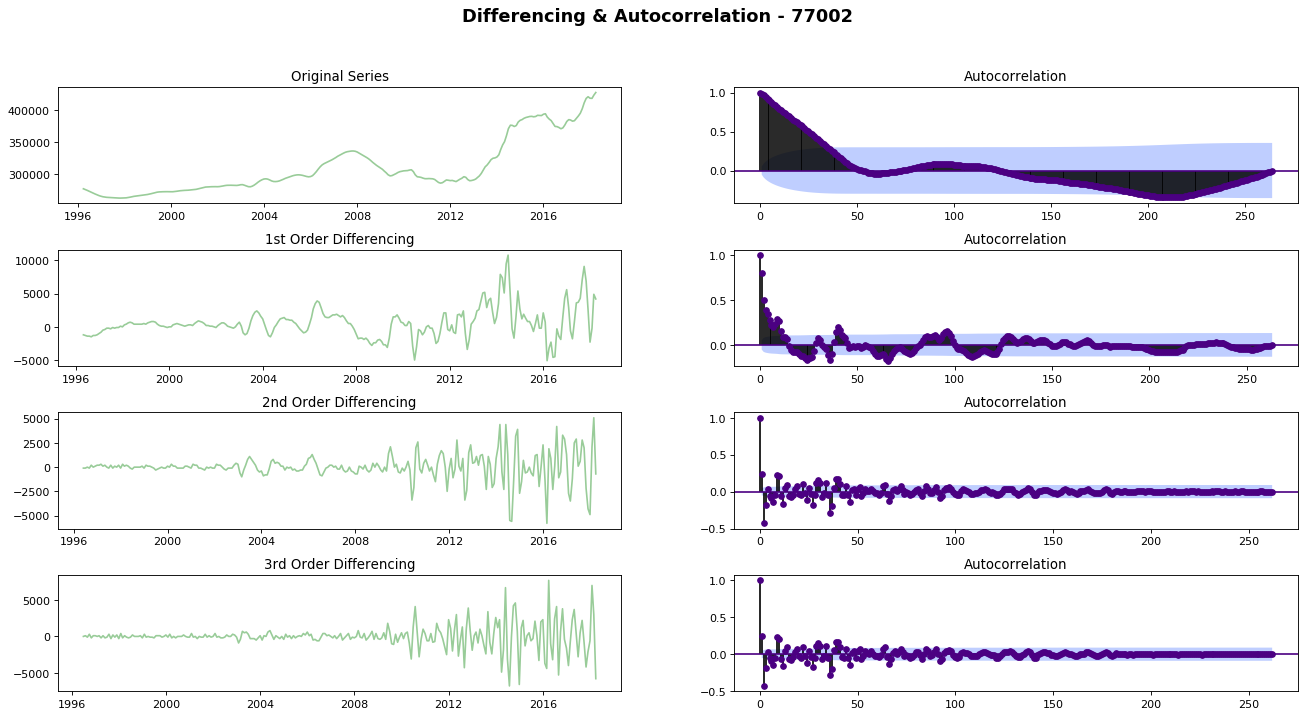

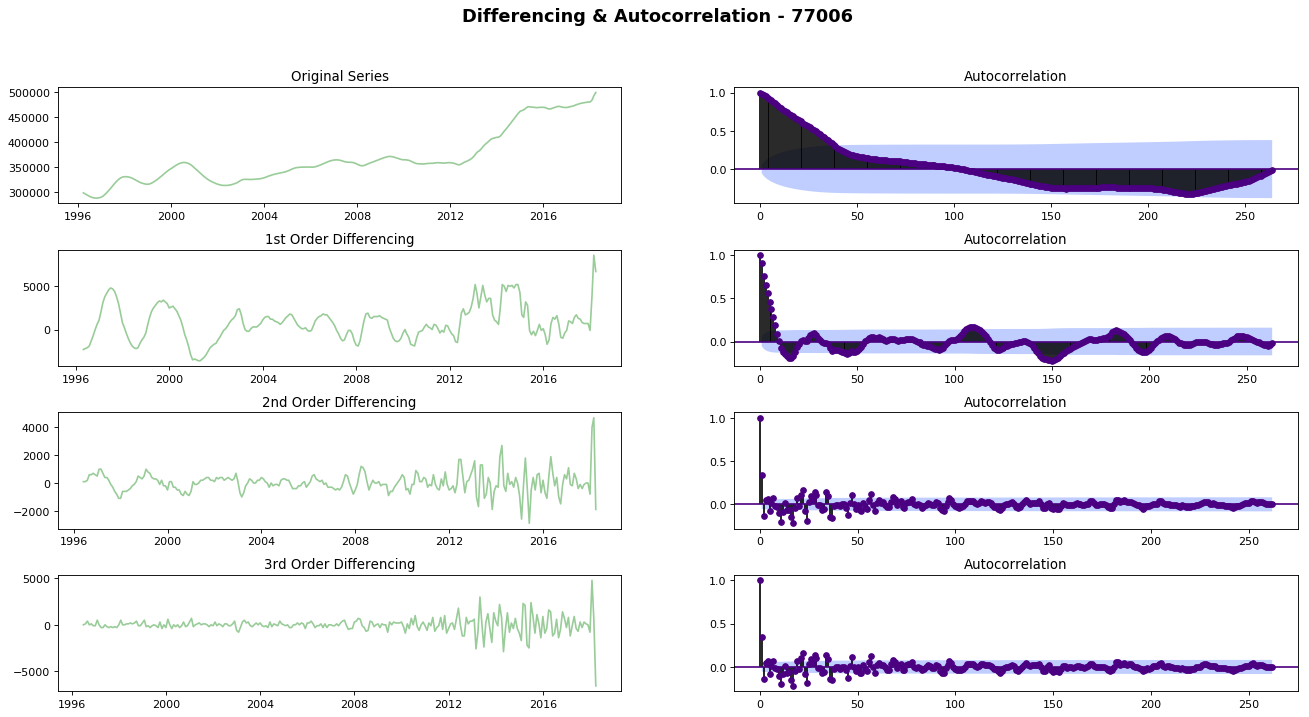

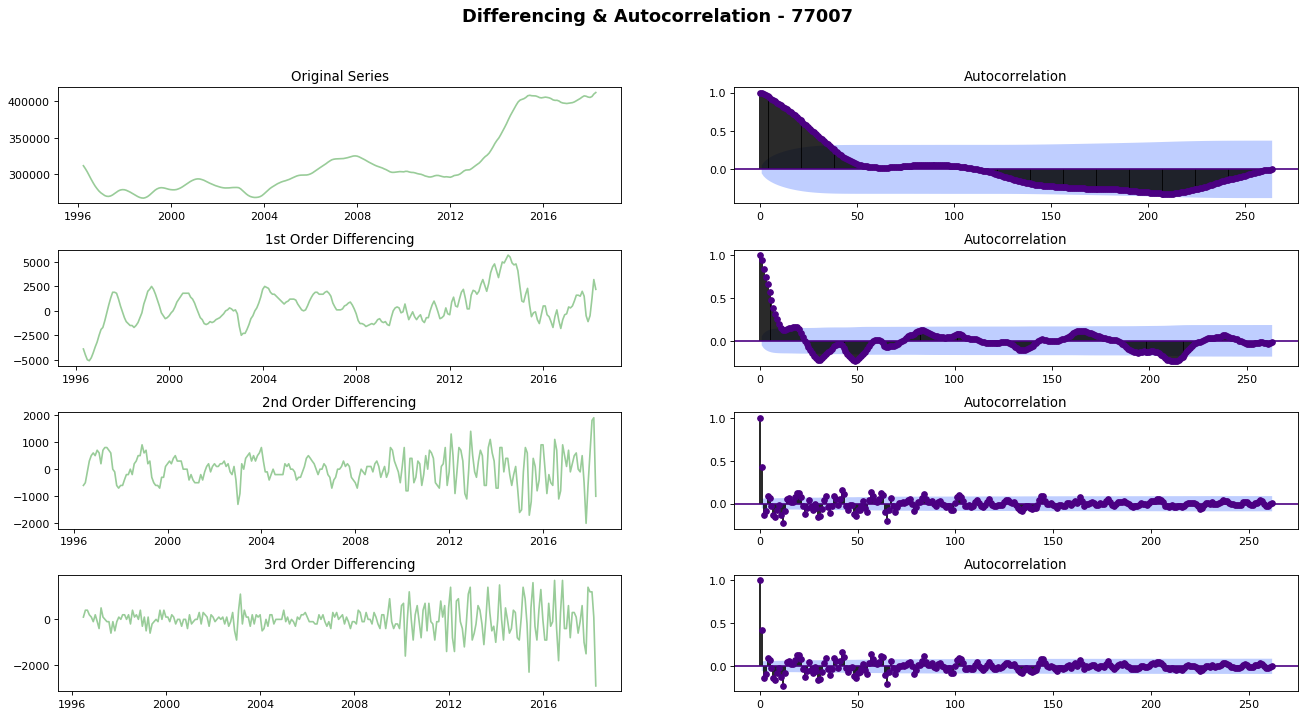

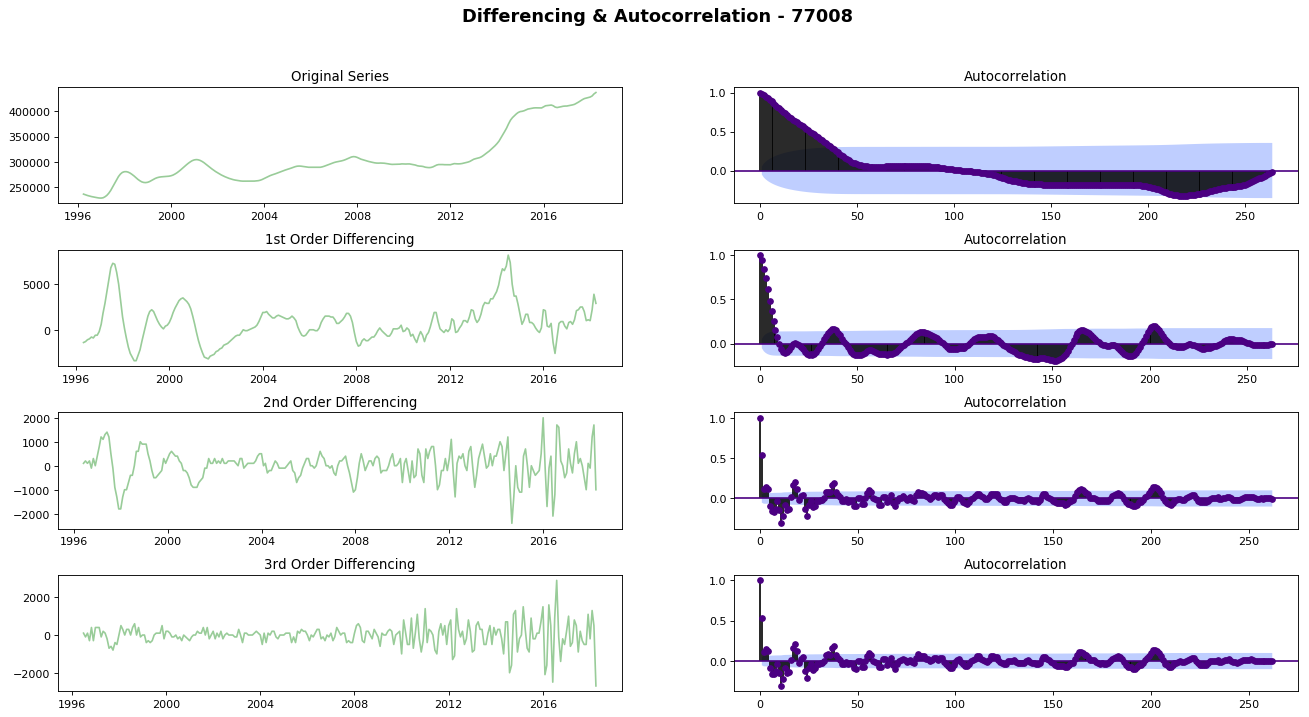

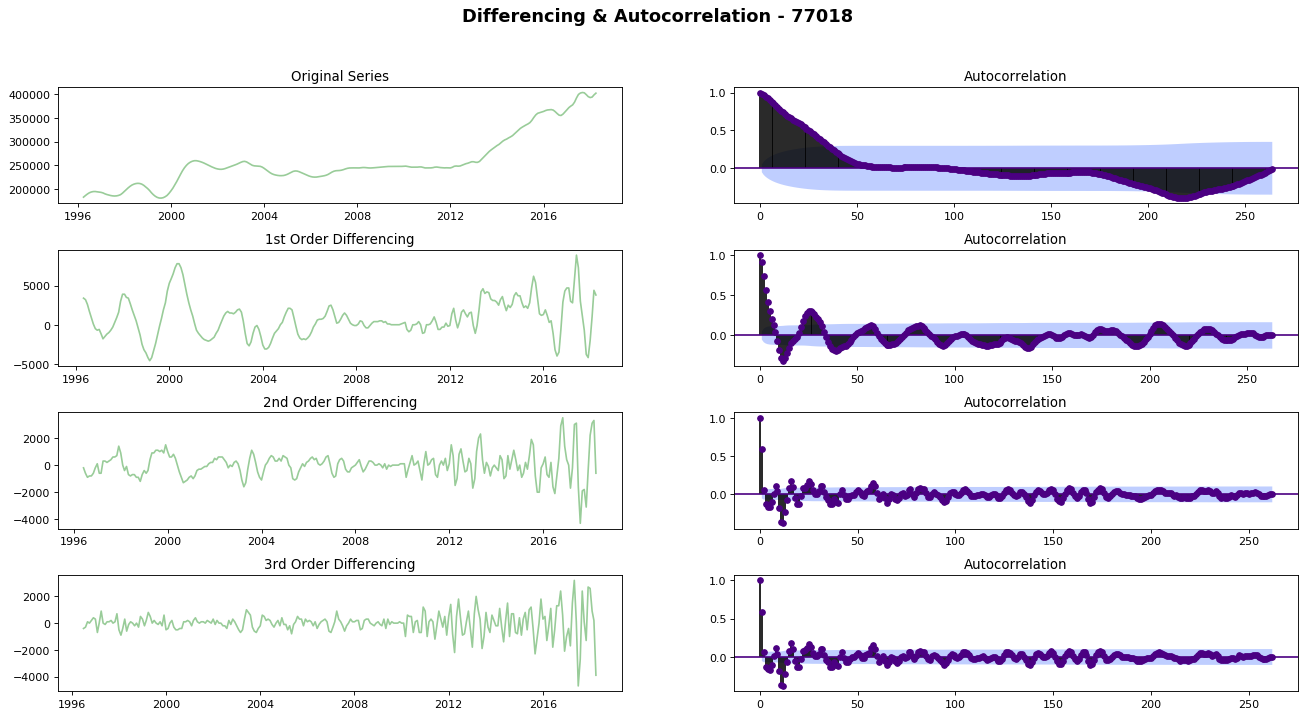

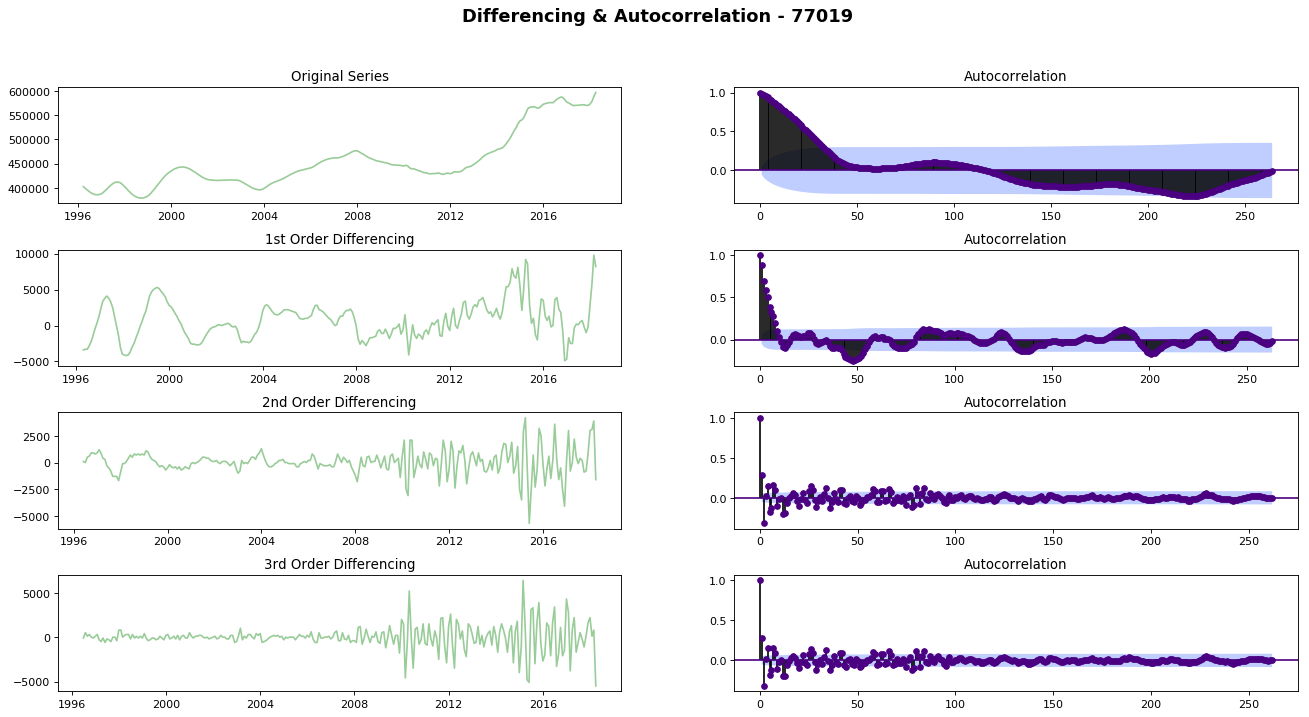

In [20]:
# check ACF and PACF

plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':80})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Import data
for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
# Original Series
    fig, axes = plt.subplots(4, 2)
    axes[0, 0].plot(df_z.value,color='green',alpha=0.4); axes[0, 0].set_title('Original Series',fontsize=12)
    plot_acf(df_z.value, ax=axes[0, 1], color='indigo',alpha=0.4)

    # 1st Differencing
    axes[1, 0].plot(df_z.value.diff(), color='green',alpha=0.4); axes[1, 0].set_title('1st Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().dropna(), ax=axes[1, 1], color='indigo',alpha=0.4)

    # 2nd Differencing
    axes[2, 0].plot(df_z.value.diff().diff(), color='green',alpha=0.4); axes[2, 0].set_title('2nd Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().diff().dropna(), color='indigo',alpha=0.4, ax=axes[2, 1])
    
     # 3nd Differencing
    axes[3, 0].plot(df_z.value.diff().diff().diff(), color='green',alpha=0.4); axes[3, 0].set_title('3rd Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().diff().dropna(), ax=axes[3, 1],  color='indigo',alpha=0.4)

    fig.suptitle('Differencing & Autocorrelation - ' + str(z), fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace = 0.4 )
    plt.show()


We are not able to reduce heteroscedasticity

## Seasonal Decomposition, Model Building, and Forecasting

Zip:  77002
ADF Statistic Residual: -5.564450
p-value: 0.000002


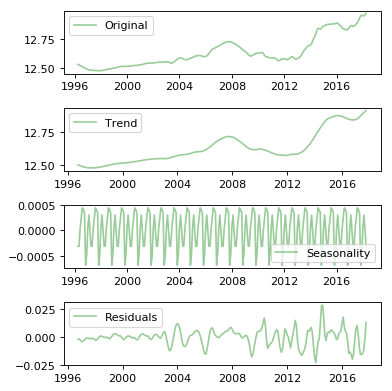

Fit ARIMA: order=(1, 1, 1); AIC=4451.262, BIC=4465.566, Fit time=0.115 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4819.852, BIC=4827.004, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4548.556, BIC=4559.284, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4563.081, BIC=4573.808, Fit time=0.050 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4451.973, BIC=4469.853, Fit time=0.149 seconds
Fit ARIMA: order=(1, 1, 2); AIC=4422.934, BIC=4440.813, Fit time=0.170 seconds
Fit ARIMA: order=(2, 1, 3); AIC=4402.618, BIC=4427.650, Fit time=0.377 seconds
Fit ARIMA: order=(1, 1, 3); AIC=4413.511, BIC=4434.967, Fit time=0.229 seconds
Fit ARIMA: order=(3, 1, 3); AIC=4403.604, BIC=4432.212, Fit time=0.589 seconds
Fit ARIMA: order=(2, 1, 2); AIC=4415.011, BIC=4436.467, Fit time=0.247 seconds
Fit ARIMA: order=(2, 1, 4); AIC=4404.154, BIC=4432.762, Fit time=0.705 seconds
Fit ARIMA: order=(3, 1, 4); AIC=4398.614, BIC=4430.798, Fit time=0.386 seconds
Fit ARIMA: order=(4, 1, 4); AIC=4407.973, BIC=4443.7

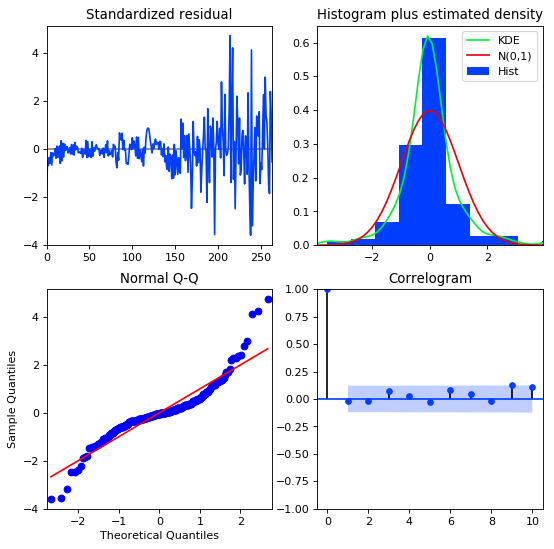

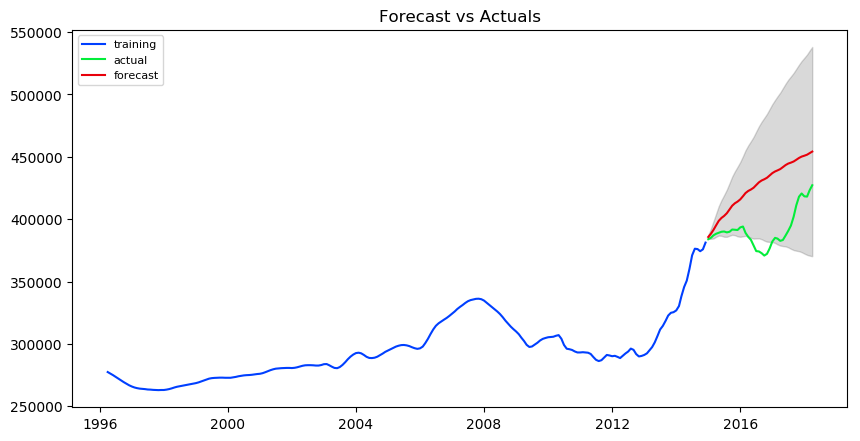

Mean Error : 34987.17392402132


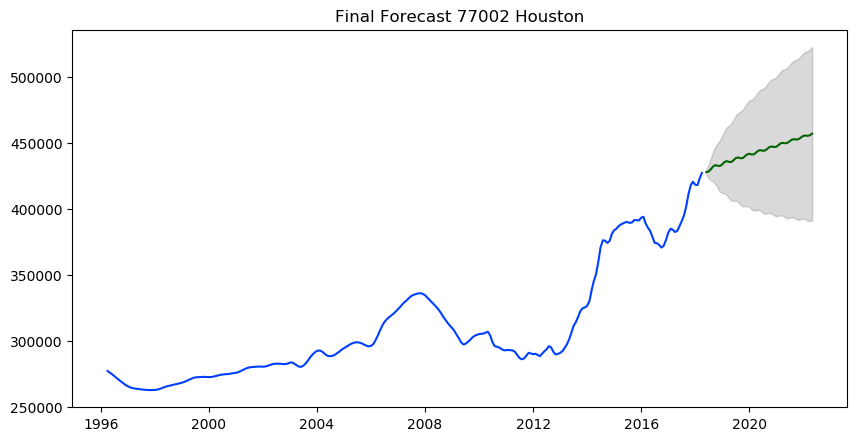

77002
Model Order:  (5, 1, 5)
Upside case 2022:  522633.45213165693 ROI:  22.119086033513074
Base   case 2022:  456987.223529244 ROI:  6.780118721381956
Low    case 2022:  391340.9949268311 ROI:  -8.558848590749163
Zip:  77006
ADF Statistic Residual: -7.343792
p-value: 0.000000


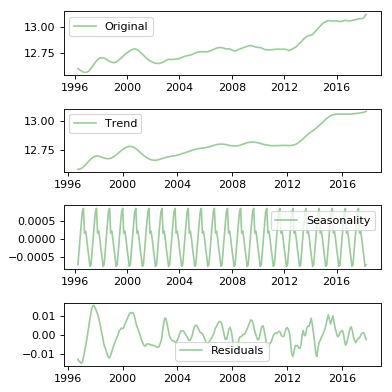

Fit ARIMA: order=(1, 1, 1); AIC=4160.726, BIC=4175.030, Fit time=0.091 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4767.614, BIC=4774.766, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4251.917, BIC=4262.645, Fit time=0.046 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4459.759, BIC=4470.486, Fit time=0.044 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4162.386, BIC=4180.265, Fit time=0.124 seconds
Fit ARIMA: order=(1, 1, 2); AIC=4161.927, BIC=4179.807, Fit time=0.127 seconds
Fit ARIMA: order=(2, 1, 2); AIC=4148.942, BIC=4170.397, Fit time=0.216 seconds
Fit ARIMA: order=(3, 1, 2); AIC=4137.709, BIC=4162.741, Fit time=0.224 seconds
Fit ARIMA: order=(3, 1, 1); AIC=4157.382, BIC=4178.838, Fit time=0.161 seconds
Fit ARIMA: order=(3, 1, 3); AIC=4113.908, BIC=4142.515, Fit time=0.563 seconds
Fit ARIMA: order=(4, 1, 4); AIC=4135.788, BIC=4171.547, Fit time=0.697 seconds
Fit ARIMA: order=(2, 1, 3); AIC=4142.508, BIC=4167.540, Fit time=0.267 seconds
Fit ARIMA: order=(4, 1, 3); AIC=4132.379, BIC=4164.5

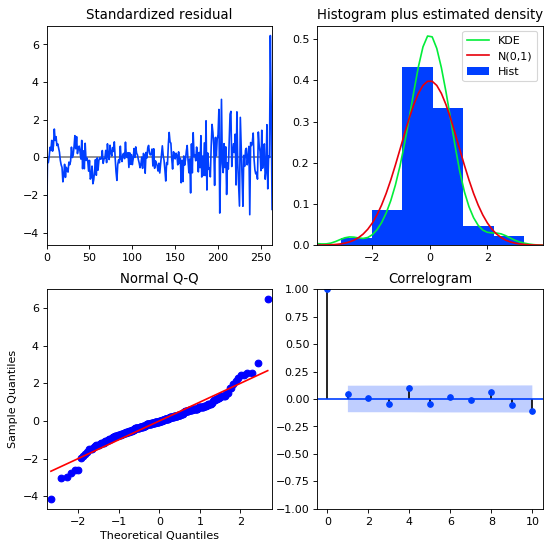

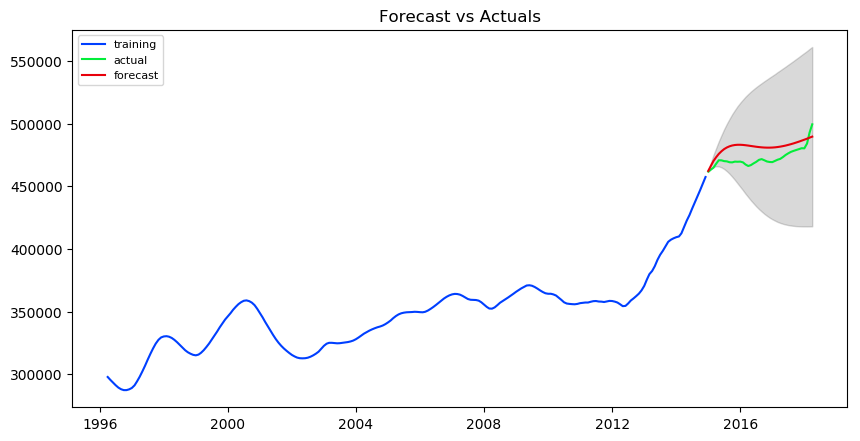

Mean Error : 8631.560757101126


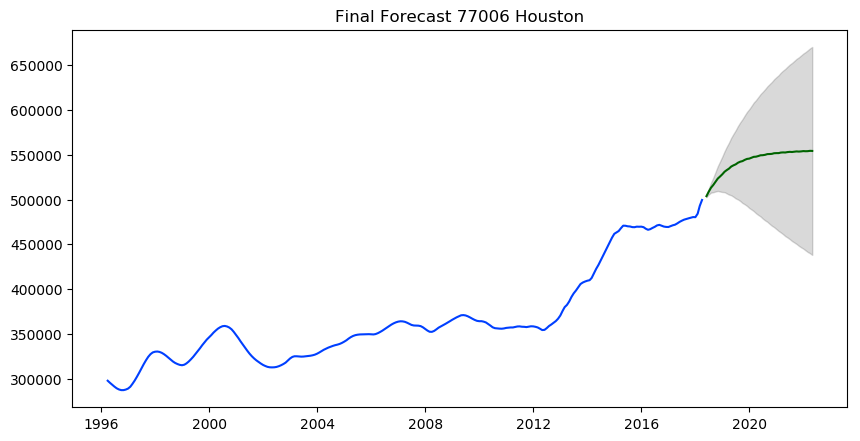

77006
Model Order:  (3, 1, 3)
Upside case 2022:  670555.8171562621 ROI:  33.07597800805061
Base   case 2022:  554382.928370464 ROI:  10.02074472597483
Low    case 2022:  438210.0395846659 ROI:  -13.034488556100957
Zip:  77007
ADF Statistic Residual: -4.348303
p-value: 0.000366


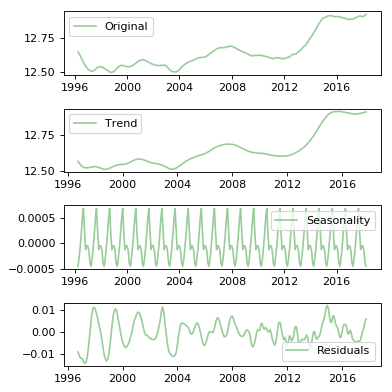

Fit ARIMA: order=(1, 1, 1); AIC=3979.039, BIC=3993.343, Fit time=0.099 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4704.496, BIC=4711.648, Fit time=0.001 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4086.062, BIC=4096.790, Fit time=0.039 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4389.452, BIC=4400.180, Fit time=0.044 seconds
Fit ARIMA: order=(2, 1, 1); AIC=3977.591, BIC=3995.471, Fit time=0.126 seconds
Fit ARIMA: order=(2, 1, 0); AIC=4022.788, BIC=4037.092, Fit time=0.067 seconds
Fit ARIMA: order=(2, 1, 2); AIC=3982.089, BIC=4003.545, Fit time=0.229 seconds
Fit ARIMA: order=(3, 1, 2); AIC=3961.656, BIC=3986.688, Fit time=0.255 seconds
Fit ARIMA: order=(4, 1, 2); AIC=3967.519, BIC=3996.127, Fit time=0.263 seconds
Fit ARIMA: order=(3, 1, 1); AIC=3970.940, BIC=3992.396, Fit time=0.217 seconds
Fit ARIMA: order=(3, 1, 3); AIC=3963.581, BIC=3992.188, Fit time=0.420 seconds
Fit ARIMA: order=(4, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.785 seconds
77007
                            

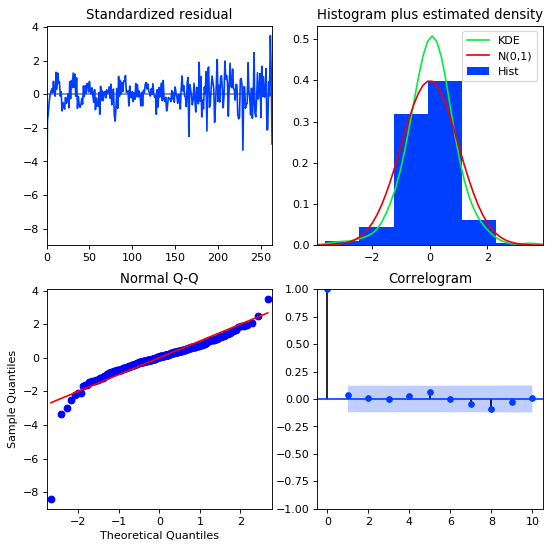

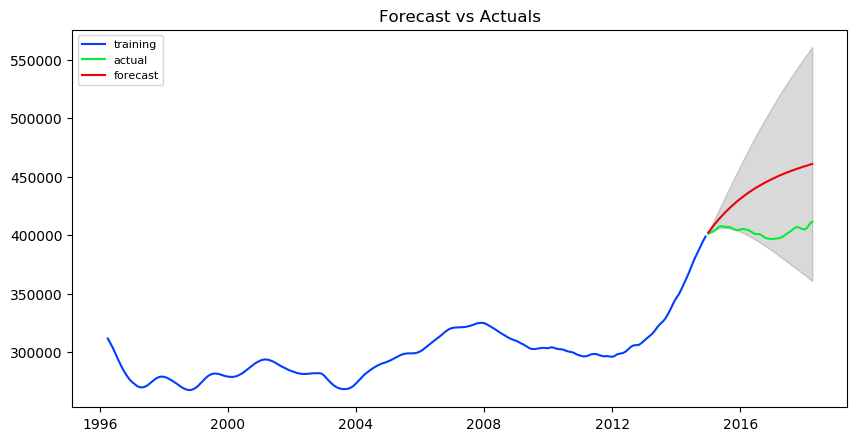

Mean Error : 35538.94738703756


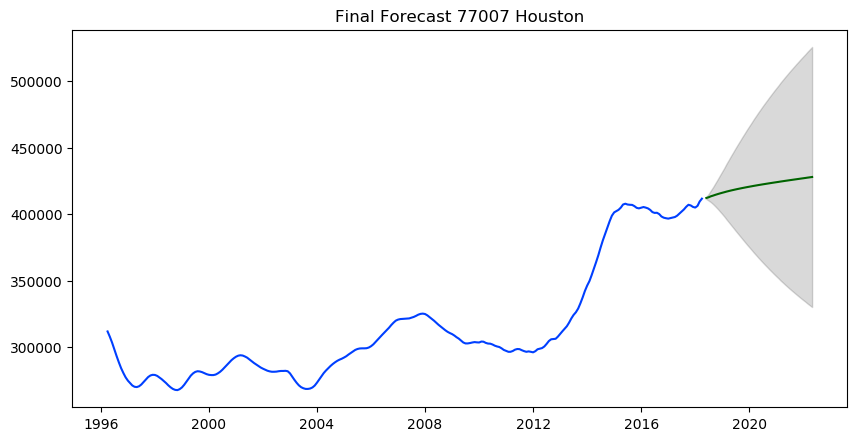

77007
Model Order:  (3, 1, 2)
Upside case 2022:  525735.9815936751 ROI:  27.538456656068632
Base   case 2022:  427984.2032996344 ROI:  3.824822102815665
Low    case 2022:  330232.4250055937 ROI:  -19.888812450437303
Zip:  77008
ADF Statistic Residual: -4.297279
p-value: 0.000449


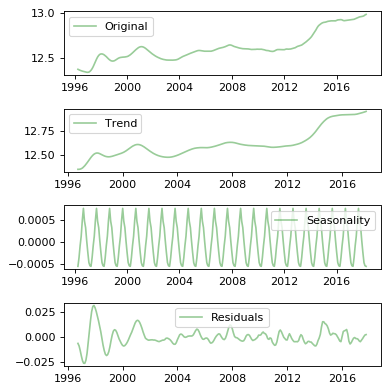

Fit ARIMA: order=(1, 1, 1); AIC=4021.372, BIC=4035.676, Fit time=0.125 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4776.136, BIC=4783.288, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4147.818, BIC=4158.546, Fit time=0.037 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4450.395, BIC=4461.123, Fit time=0.044 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4011.876, BIC=4029.756, Fit time=0.147 seconds
Fit ARIMA: order=(2, 1, 0); AIC=4043.683, BIC=4057.986, Fit time=0.120 seconds
Fit ARIMA: order=(2, 1, 2); AIC=4008.770, BIC=4030.225, Fit time=0.168 seconds
Fit ARIMA: order=(3, 1, 3); AIC=3991.108, BIC=4019.716, Fit time=0.308 seconds
Fit ARIMA: order=(2, 1, 3); AIC=3993.035, BIC=4018.067, Fit time=0.219 seconds
Fit ARIMA: order=(4, 1, 3); AIC=3974.312, BIC=4006.496, Fit time=0.365 seconds
Fit ARIMA: order=(4, 1, 2); AIC=3976.349, BIC=4004.957, Fit time=0.267 seconds
Fit ARIMA: order=(4, 1, 4); AIC=3976.227, BIC=4011.987, Fit time=0.492 seconds
Fit ARIMA: order=(3, 1, 2); AIC=4010.272, BIC=4035.3

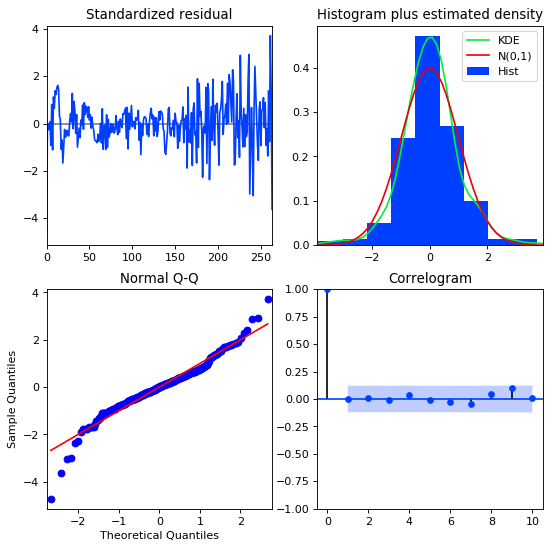

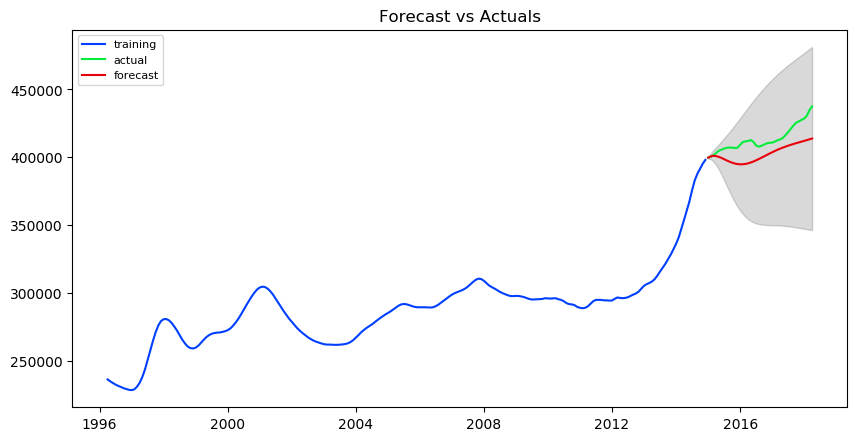

Mean Error : -10721.957983388078


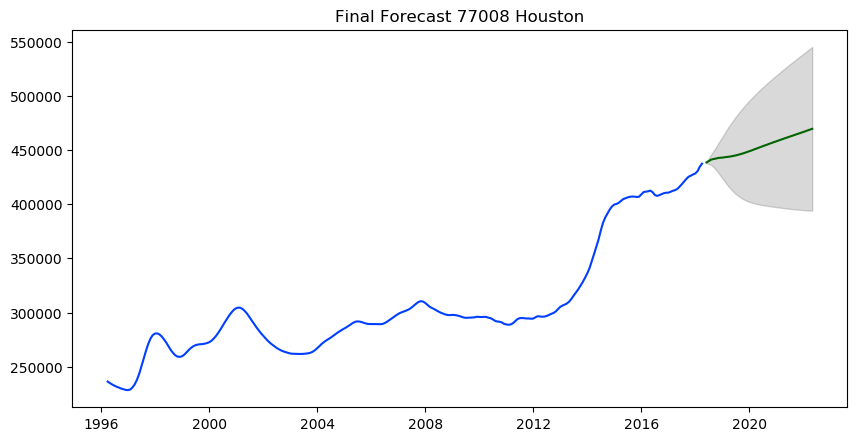

77008
Model Order:  (4, 1, 3)
Upside case 2022:  545453.8283376243 ROI:  24.323536974240838
Base   case 2022:  469777.72005134186 ROI:  7.074924978483171
Low    case 2022:  394101.6117650594 ROI:  -10.173687017274496
Zip:  77018
ADF Statistic Residual: -5.809605
p-value: 0.000000


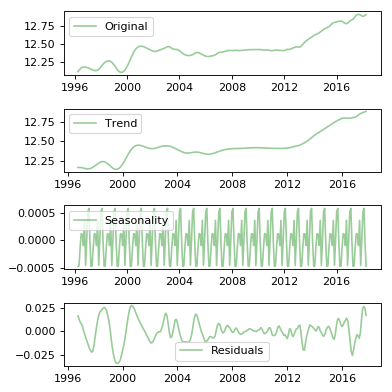

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=4857.604, BIC=4864.756, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4357.722, BIC=4368.450, Fit time=0.029 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4535.367, BIC=4546.095, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0); AIC=4210.465, BIC=4224.769, Fit time=0.118 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4146.634, BIC=4164.514, Fit time=0.121 seconds
Fit ARIMA: order=(3, 1, 2); AIC=4133.047, BIC=4158.078, Fit time=0.266 seconds
Fit ARIMA: order=(2, 1, 2); AIC=4132.868, BIC=4154.324, Fit time=0.158 seconds
Fit ARIMA: order=(2, 1, 3); AIC=4138.298, BIC=4163.330, Fit time=0.310 seconds
Fit ARIMA: order=(3, 1, 3); AIC=4132.290, BIC=4160.897, Fit time=0.294 seconds
Fit ARIMA: order=(4, 1, 3); AIC=4133.604, BIC=4165.787, Fit time=0.295 seconds
Fit ARIMA: order=(3, 1, 4); AIC=4136.674, BIC=4168.858, Fit time=0.569 seconds
Fit ARIMA: order=(4, 1, 4); AIC=4134.862, BIC=4170.621, Fit time

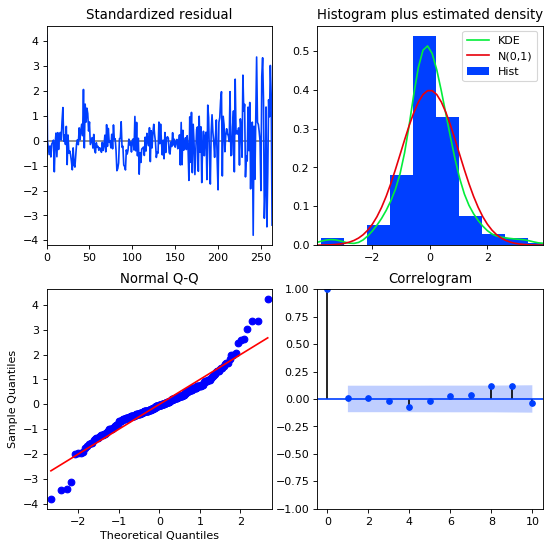

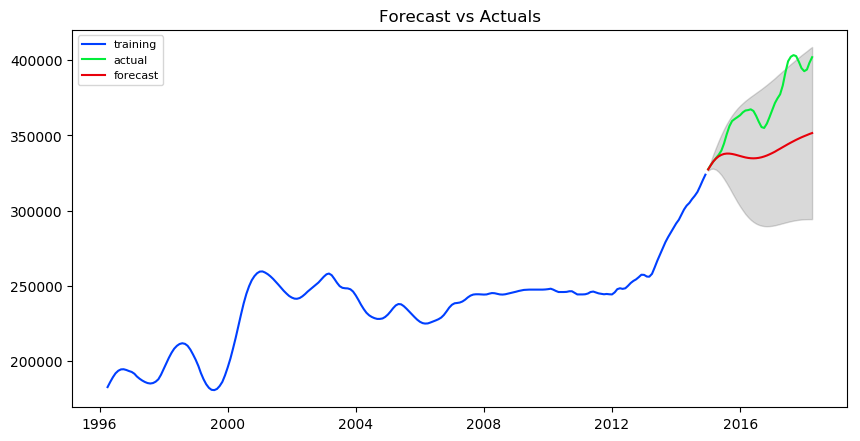

Mean Error : -29075.941202338297


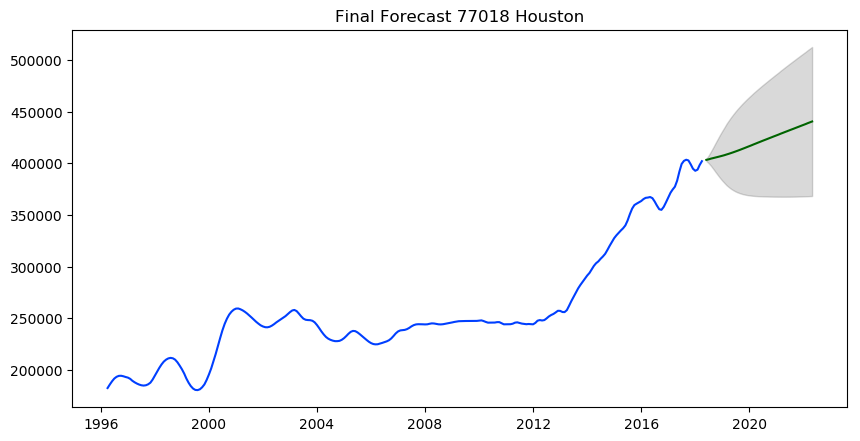

77018
Model Order:  (3, 1, 3)
Upside case 2022:  512677.21552439115 ROI:  27.09681514445505
Base   case 2022:  440535.6164975895 ROI:  9.21233111027315
Low    case 2022:  368394.01747078786 ROI:  -8.672152923908753
Zip:  77019
ADF Statistic Residual: -5.873383
p-value: 0.000000


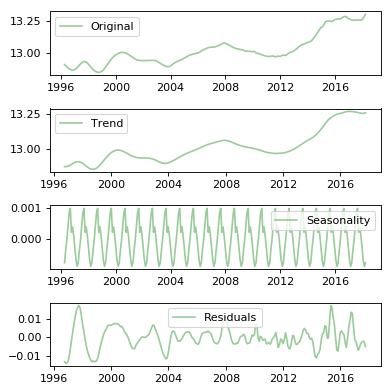

Fit ARIMA: order=(1, 1, 1); AIC=4352.995, BIC=4367.299, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4899.790, BIC=4906.941, Fit time=0.001 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4469.362, BIC=4480.090, Fit time=0.030 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4587.692, BIC=4598.420, Fit time=0.049 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.223 seconds
77019
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2172.498
Method:                       css-mle   S.D. of innovations            901.638
Date:                Wed, 18 Sep 2019   AIC                           4352.995
Time:                        16:31:49   BIC         

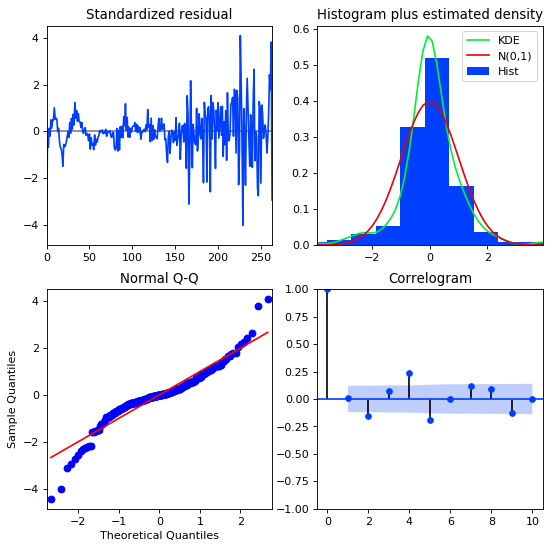

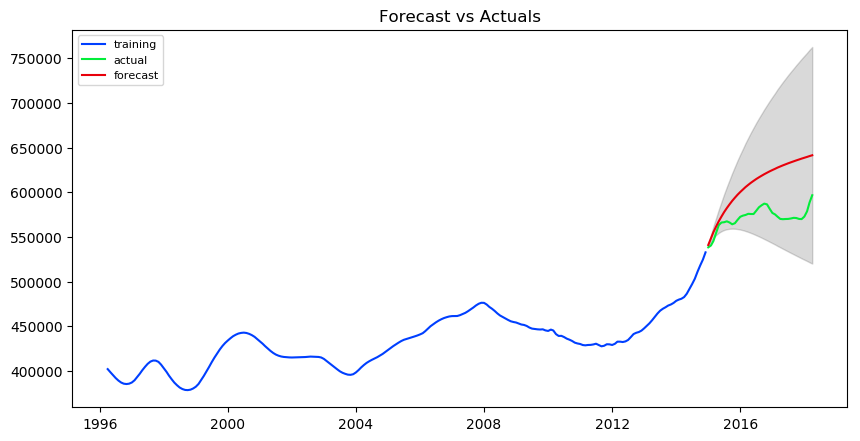

Mean Error : 37917.068283774446


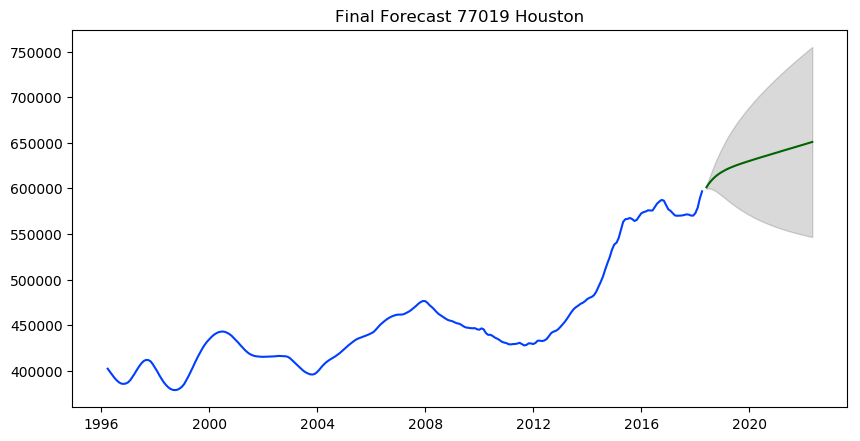

77019
Model Order:  (1, 1, 1)
Upside case 2022:  755055.0928267373 ROI:  25.597201479944886
Base   case 2022:  650841.8622728355 ROI:  8.262188129127221
Low    case 2022:  546628.6317189336 ROI:  -9.072825221690442


In [22]:

# compute residuals and create an ARMA model of the residuals.

from statsmodels.tsa.seasonal import seasonal_decompose

residuals_list = []
for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
    ts = df_z.value
    decomposition = seasonal_decompose(np.log(ts))

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    df_z['res'] = residual
    residuals_list.append(residual)
    
    # Plot gathered statistics
    plt.figure(figsize=(5,5))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    result = adfuller(residual.dropna())
    print('Zip: ', z)
    print('ADF Statistic Residual: %f' % result[0])
    print('p-value: %f' % result[1])
    plt.show()
    

    model = pm.auto_arima(df_z.value.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(z)
    print(model.summary())
    model.plot_diagnostics(figsize=(8, 8))
    plt.show()
    
    #============= PLOT TRAIN AND TEST =========
    #df_z.reset_index(inplace=True)
    train = df_z.value.dropna()[:225]
    test = df_z.value.dropna()[225:]
    
    test_index = zip_df.index[-40:]
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit(disp=-1)  
                   
    # Forecast
    fc, se, conf = fitted.forecast(40, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_index)
    lower_series = pd.Series(conf[:, 0], index=test_index)
    upper_series = pd.Series(conf[:, 1], index=test_index)

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print('Mean Error :', np.mean(fc_series - test))
    
    
    #==============PLOT FORECAST =========================
    #df_z.reset_index(inplace=True)
    n_periods = 48
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    #index_of_fc = np.arange(len(df_z.value), len(df_z.value)+n_periods)
    
    index_of_fc = pd.date_range('2018-05-01', periods=48, freq='M')
    # make series for plotting purpose
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))

    # Plot
    plt.figure(figsize=(10,5), dpi=100)

    plt.plot(fc_series, color='darkgreen')
    plt.plot(df_z.value)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("Final Forecast " + str(z) + ' ' + df_z.City[0])
    plt.show()
    print(z)
    print('Model Order: ', model.order)
    print('Upside case 2022: ', upper_series[-1], 'ROI: ', (upper_series[-1]-fc_series[-48])/fc_series[-48]*100)
    print('Base   case 2022: ', fc_series[-1], 'ROI: ', (fc_series[-1]-fc_series[-48])/fc_series[-48]*100)
    print('Low    case 2022: ', lower_series[-1], 'ROI: ', (lower_series[-1]-fc_series[-48])/fc_series[-48]*100)



# Interpreting Results

There were some zip codes not included in analysis because of lack of data

Overall, the test data fit the trained data well. 

# Future Work

In [ ]:
Suggestions from Roovy welcome